
<span style="color:red;font-size: 20px;">Import the data and libraries</span>


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv("/home/cw2378/persistent/private-90d/default data.csv",header = 1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


<span style="color:red;font-size: 20px;">Data Cleanning and Processing</span>

Summary: 1. Check if any missing values: no missing data found
         2. Check extreme or unexpected values and impute those: 
        A. Education, Marriage: found data other than data dictionary-> impute using 'others' category
        B. Pay: found 0 and -2 not in data dictionary
[Assumptions] -2 is wrongly input data -> impute with median
              There are a large part of 0 exists. It's not "no payment due/ already paid in full" upon checking (only a small portion of 0 are found to have similiar payment and billing amount of previous month)

        C. Sex, Age, Amount of given credit, Bill Amount,Payment Amount: No unexpected values found
        3. Rename columns for easier understanding:
        PAY_0 -> PAY_1 to match bills and PAY_AMT columns each month respectively

In [8]:
#1. check if any missing values 
df.isnull().sum()
#[Result] No missing value is found in the data

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [9]:
#2.Check extreme values or any wrong/unexpected data
df1 = df.copy()
# Check for any values of 'SEX' that are not 1 or 2
unexpected_sex = df[~df['SEX'].isin([1, 2])]
# print('Unexpected values for SEX:', unexpected_sex)
#[Result]: No values other than 1 and 2 found

# Check for any values of 'EDUCATION' that are not 1, 2, 3, or 4
unexpected_education = df[~df['EDUCATION'].isin([1, 2, 3, 4])]
# print('Unexpected values for EDUCATION:', unexpected_education['EDUCATION'])
df1[~df1['EDUCATION'].isin([1, 2, 3, 4])]['EDUCATION'] = 4
#[Result]: Unexpected values found (5,6) -> impute using 4 ('Others')

# Check for any values of 'MARRIAGE' that are not 1, 2, or 3
unexpected_marriage = df[~df['MARRIAGE'].isin([1, 2, 3])]
# print('Unexpected values for MARRIAGE:', unexpected_marriage['MARRIAGE'])
df1[~df1['MARRIAGE'].isin([1, 2, 3])]['MARRIAGE'] = 3
#[Result]: Unexpected values found (0 -> impute using 3 ('Others')

# Check for any values of 'PAY_1' to 'PAY_6' that are not from -1 to 9, excluding 0 
df1 = df1.rename(columns={'PAY_0': 'PAY_1'}) #rename to ensure consistency in months of all pay status, bill amount and pay amount 

for i in range(1, 7):  
    col = 'PAY_' + str(i)
    valid_values = list(range(-1, 10))
    valid_values.remove(0)
    unexpected_pay = df1[~df1[col].isin(valid_values)][col]
    # print(f'Unexpected values for {col}:', unexpected_pay.unique(),)
    # print(f'Unexpected values count for {col}:', unexpected_pay.count(),)
#[Result]: Found large amount of 0 and some -2 in the pay column which are not described by attributes info.
#[Assumptions]: -2 is wrongly input data and will be imputed by median.
for i in range(1, 7): 
    pay_col = 'PAY_' + str(i)
    median = df1[df1[pay_col] != -2][pay_col].median()
    df1.loc[df1[pay_col] == -2, pay_col] = median
#[Assumptions]: 0 may be no payment needed at the due this month, but not true upon checking (see appendix 1)Given the large amount, I treat it as a sepearte category. 

# Check for any negative values in 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', etc.
for col in ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    negative_values = df1[df1[col] < 0]
    # print(f'Negative values for {col}:', negative_values)
#[Result]: No strange value found

<ipython-input-9-f46f39b78c13>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-f46f39b78c13>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<span style="color:red;font-size: 20px;">EDA</span>

Summary: 
1. Descriptive statistics: n =30000. See details in table below.
A. Demographics info is mostly normally distributed, with age slightly skewed towards young (30s) and slightly more females(1 vs 1.5)
B. balance limit, payment amount and bill amount are mostly left skewed
c. default payment next month(predicting variable) is heavily skewed (median is 0) -> undersampling/oversampling may be needed here to deal with the unbalaced data

2. correlations of independent variables
Limit Balance, pay status and payment amount are most correlated with our predicting variable- default payment next month (r>0.05). Multicollearity is also checked using VIF. 

                 ID       LIMIT_BAL  ...       PAY_AMT6  default payment next month
count  30000.000000    30000.000000  ...   30000.000000                30000.000000
mean   15000.500000   167484.322667  ...    5215.502567                    0.221200
std     8660.398374   129747.661567  ...   17777.465775                    0.415062
min        1.000000    10000.000000  ...       0.000000                    0.000000
25%     7500.750000    50000.000000  ...     117.750000                    0.000000
50%    15000.500000   140000.000000  ...    1500.000000                    0.000000
75%    22500.250000   240000.000000  ...    4000.000000                    0.000000
max    30000.000000  1000000.000000  ...  528666.000000                    1.000000

[8 rows x 25 columns]


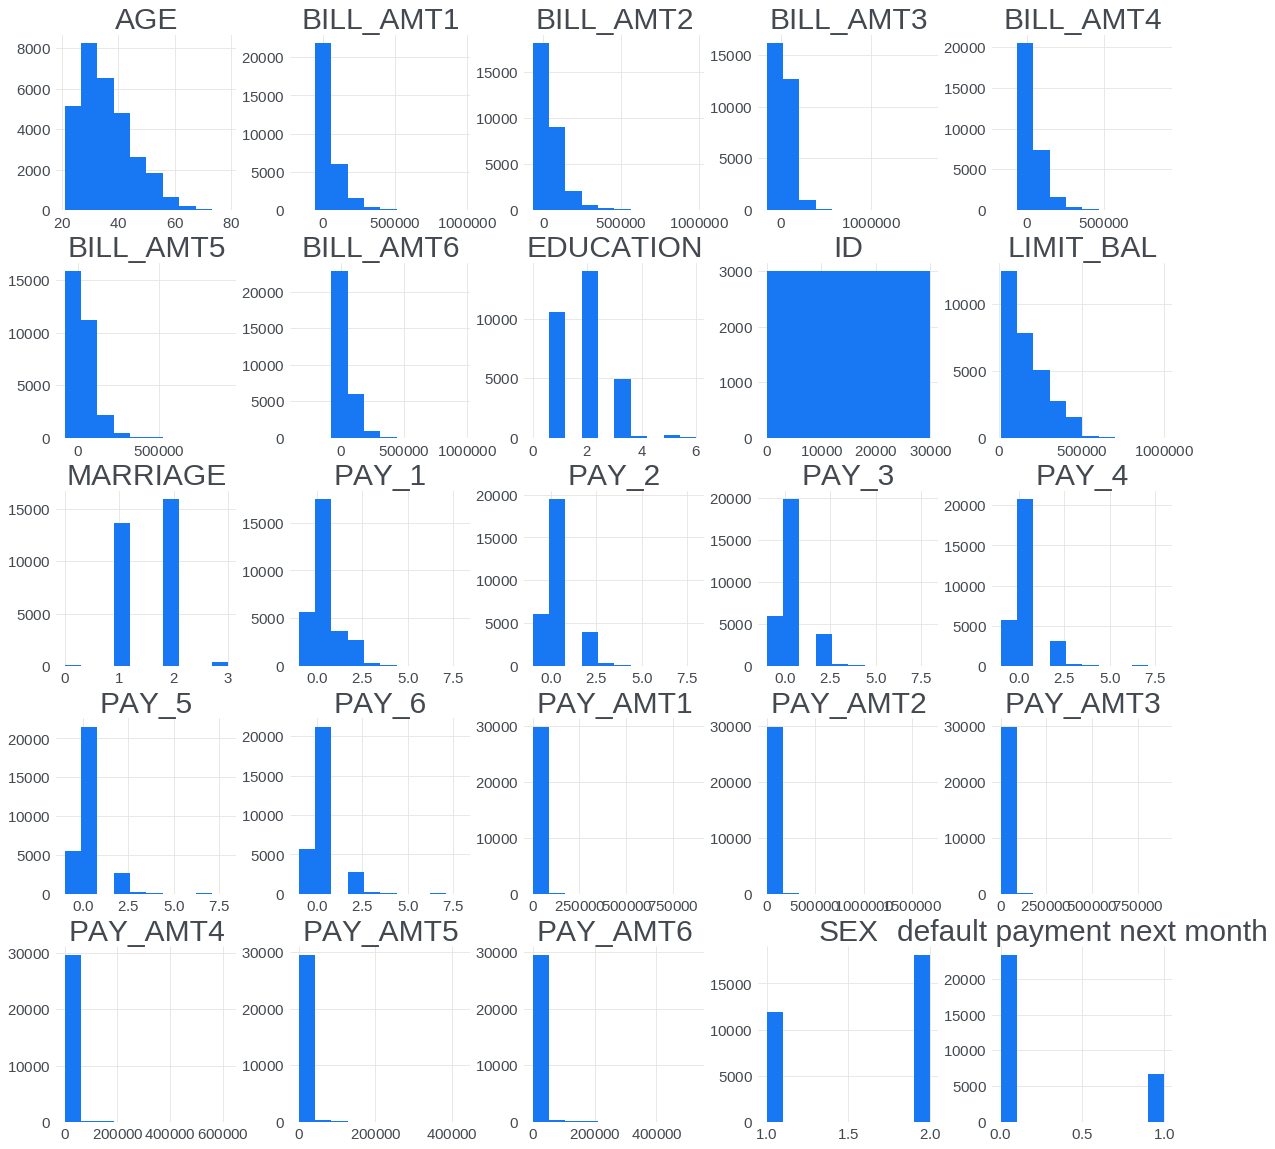

                                  ID  ...  default payment next month
ID                          1.000000  ...                   -0.013952
LIMIT_BAL                   0.026179  ...                   -0.153520
SEX                         0.018497  ...                   -0.039961
EDUCATION                   0.039177  ...                    0.028006
MARRIAGE                   -0.029079  ...                   -0.024339
AGE                         0.018678  ...                    0.013890
PAY_1                      -0.002802  ...                    0.349615
PAY_2                       0.003701  ...                    0.302468
PAY_3                      -0.003407  ...                    0.271348
PAY_4                       0.016411  ...                    0.255820
PAY_5                      -0.005361  ...                    0.247036
PAY_6                      -0.002011  ...                    0.228762
BILL_AMT1                   0.019389  ...                   -0.019644
BILL_AMT2           

In [10]:
# descriptive statistics
print(df1.describe())
# Plot histograms for each variable
# df1.drop('ID', axis=1, inplace=True) #No need to plot ID
df1.hist(figsize=(20, 20))
# plt.tight_layout()  
plt.show()

# Compute pairwise correlation of columns, excluding NA/null values
corrMatrix = df1.corr()
print(corrMatrix)

In [11]:
# Get absolute value of correlation coefficient of each feature and the target
target_corr = abs(corrMatrix['default payment next month'])
print(target_corr)
print(target_corr[target_corr > 0.05])
# [Result]:  Limit Balance, pay status and payment amount are most correlated with our predicting variable- default payment next month (r>0.05)

ID                            0.013952
LIMIT_BAL                     0.153520
SEX                           0.039961
EDUCATION                     0.028006
MARRIAGE                      0.024339
AGE                           0.013890
PAY_1                         0.349615
PAY_2                         0.302468
PAY_3                         0.271348
PAY_4                         0.255820
PAY_5                         0.247036
PAY_6                         0.228762
BILL_AMT1                     0.019644
BILL_AMT2                     0.014193
BILL_AMT3                     0.014076
BILL_AMT4                     0.010156
BILL_AMT5                     0.006760
BILL_AMT6                     0.005372
PAY_AMT1                      0.072929
PAY_AMT2                      0.058579
PAY_AMT3                      0.056250
PAY_AMT4                      0.056827
PAY_AMT5                      0.055124
PAY_AMT6                      0.053183
default payment next month    1.000000
Name: default payment nex


<span style="color:red;font-size: 20px;">Feature Engineering</span>

Summary: 
1. Creating new features for easier interpretation: payment/bill trend in past 6 months, average payment/bill amount, total delays in past 6 months, the longest time delayed
2. feature selection: check VIF and correlation with lables again with the newly generated features. 
Limit Balance, pay status and payment amount, pay trend, delay most and total delays are most correlated with our predicting variable- default payment next month (r>0.05)

 


In [12]:
#Creating new features for easier interpretation
df1["pay_trend"] = (
    df1[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].diff(axis=1).mean(axis=1)
)
df1["delay_most"] = df1[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].max(
    axis=1
)
df1["total_delays"] = df1[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].apply(
    lambda i: (i > -1).sum(), axis=1
)
df1["avg_bill"] = df1[
    ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
].mean(axis=1)
df1["bill_trend"] = (
    df1[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]]
    .diff(axis=1)
    .mean(axis=1)
)
df1["avg_payment"] = df1[
    ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
].mean(axis=1)
df1["avg_payment_ratio"] = (
    df1["PAY_1"] + df1["PAY_2"] + df1["PAY_3"] + df1["PAY_4"] + df1["PAY_5"] + df1["PAY_6"] \
) / (
    df1["BILL_AMT1"]
    + df1["BILL_AMT2"]
    + df1["BILL_AMT3"]
    + df1["BILL_AMT4"]
    + df1["BILL_AMT5"]
    + df1["BILL_AMT6"]
)
df1["avg_payment_ratio"] = df1["avg_payment_ratio"].replace([np.inf, -np.inf], np.nan).fillna(0)  #fill the inf and nan of average with 0

In [13]:
# Compute pairwise correlation again of columns to select features and check multicollearity 

# Get variables for which to compute VIF (only keep those VIF <5) and add intercept term
X = df1.drop(["default payment next month","ID"], axis=1)
X = df1.assign(const=1)
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
filtered_vif = vif[vif["VIF"] <= 5] # Filter out variables with VIF > 5 
print(filtered_vif)
#[Results]: Here I don't see any variables with VIF >5 so we keep all variables here

# Get absolute value of correlation coefficient of each feature and the target again
corrMatrix = df1.corr()
target_corr = abs(corrMatrix['default payment next month'])
print(target_corr)
print(target_corr[target_corr > 0.05])
# [Result]:  Limit Balance, pay status and payment amount, pay trend, delay most and total delays are most correlated with our predicting variable- default payment next month (r>0.05)


/mnt/xarfuse/uid-25612/f4b84613-seed-nspid4026533684_cgpid8785546-ns-4026533681/statsmodels/stats/outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



                     variables       VIF
0                           ID  1.015597
1                    LIMIT_BAL  1.460215
2                          SEX  1.022634
3                    EDUCATION  1.130466
4                     MARRIAGE  1.232572
5                          AGE  1.275376
7                        PAY_2  2.722074
8                        PAY_3  2.729574
9                        PAY_4  3.001623
10                       PAY_5  3.149800
18                    PAY_AMT1  1.723417
19                    PAY_AMT2  2.256009
20                    PAY_AMT3  1.779044
21                    PAY_AMT4  1.677586
22                    PAY_AMT5  1.713320
23                    PAY_AMT6  1.170556
24  default payment next month  1.209861
26                  delay_most  3.704240
27                total_delays  2.097529
31           avg_payment_ratio  1.025215
ID                            0.013952
LIMIT_BAL                     0.153520
SEX                           0.039961
EDUCATION             


<span style="color:red;font-size: 20px;">Builidng & Selecting Models</span>


1.split training,test and validation set into 70%:15%:15%
2. undersampling to deal with unbalanced labels
3. baseline model:logistic regression with no added features
   compare different models and model performance: random forest (help address unbalanced data), XGboost
4. compare the model performance and select the best model:
A. baseline: logistic regression
 [Result]: Accuracy of 77.67%, but the F1 score is 0. Not predicting default (1) cases correctly. Model may be too simple.
B. Random Forest
 [Result]:accuracy of 81.82% and a better F1 score of 49.44%. It's better than logistic regression on predicting default.
C. XGBoost
print("Performance of XGBoost:")
 [Result]: Accuracy of 82.09% and an F1 score of 48.53%. It's slightly better than RF in accuracy and slightly worse than RF on predicting false negatives.

[Evaluation criteria]: a false negative (predicting that a customer will not default when they actually will) is worse than a false positive.So recall(TP/TP+FN) is the primary criteria. XG boost performs best here but we still want improvement by tuning or trying other algorisms. 
5. Fine tuning hyperparameter on validation dataset and select the best model to test.

In [15]:
#split tranining, testing and validation set into 70%:15%:15%
X = df1[['LIMIT_BAL',  'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',  'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
        'pay_trend', 'delay_most', 'total_delays']]
y = df1["default payment next month"]

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=40)

#Address unbalanced labels 

# imblearn.over_sampling.SMOTE is not avaialble in my kernel. Separate majority and minority classes here directly:
df_majority = df1[df1["default payment next month"]==0]
df_minority = df1[df1["default payment next month"]==1]
# Downsample majority class and get the new training set
df_majority_downsampled = df_majority.sample(len(df_minority))
df_2 = pd.concat([df_majority_downsampled, df_minority])
df_2["default payment next month"].value_counts()

1    6636
0    6636
Name: default payment next month, dtype: int64

In [21]:
#Compare performance of baseline model(logistic regression), RF model and XG boost model on test data set
def apply_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix: \n{cm}")
    print(f"Recall: {recall_score(y_test, y_pred)}")

# Define the models
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# Apply Logistic Regression
print("Performance of Logistic Regression:")
apply_model(lr_model, X_train, y_train, X_test, y_test)
# [Result]: Accuracy of 77.67%, but the F1 score is 0.Not predicting default (1) cases correctly. Model may be too simple
# Apply Random Forest
print("Performance of Random Forest:")
apply_model(rf_model, X_train, y_train, X_test, y_test)
# [Result]:accuracy of 81.82% and a better F1 score of 49.44%.
# Apply XGBoost
print("Performance of XGBoost:")
apply_model(xgb_model, X_train, y_train, X_test, y_test)
#[Result]: Accuracy of 82.09% and an F1 score of 48.53%. It's slightly better than RF currently. 

# [Evaluation criteria]: a false negative (predicting that a customer will not default when they actually will) is worse than a false positive.
# So recall(TP/TP+FN) is the primary criteria. XGboost performs best here but we still want improvement by tuning or trying other algorisms. 




Performance of Logistic Regression:
Accuracy: 0.7766666666666666
F1 Score: 0.0
Confusion Matrix: 
[[3495    0]
 [1005    0]]
Recall: 0.0
Performance of Random Forest:


Accuracy: 0.8162222222222222
F1 Score: 0.4782334384858044
Confusion Matrix: 
[[3294  201]
 [ 626  379]]
Recall: 0.37711442786069654
Performance of XGBoost:
[19:03:47] WARNING: /home/engshare/third-party2/xgboost/1.1.1/src/build-platform010/shared/src/learner.cc:505: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Accuracy: 0.8208888888888889
F1 Score: 0.48531289910600256
Confusion Matrix: 
[[3314  181]
 [ 625  380]]
Recall: 0.3781094527363184


In [23]:
# 5. Use grid search to tune hyperparameters in the validation data set and select the best model. 
# After selecting the model that performed best on the validation set, and finally test it on the test set.
# Grid search for best parameters (Not being run here due to memory and cpu limits)

<span style="color:red;font-size: 20px;">Next Steps</span>

If I have more time,I would:

1. Check with stakeholders on implication of 0 in payment status and setting up business metrics for measurement
2. try different feature selections and new features
3. fine tuning the hyperparameters on validation set and selecting the best model to test on the test data set again.

<span style="color:red;font-size: 20px;">Appendix</span>


In [14]:
#Appendix 1
for i in range(1, 6): 
    pay_col = 'PAY_' + str(i)
    bill_col = 'BILL_AMT' + str(i+1)  # bill amount for the previous month
    pay_amt_col = 'PAY_AMT' + str(i)  # payment for the current month

    pay_0_rows = df[df[pay_col] == 0]

    # Check if BILL_AMT for the previous month is close to zero
    bill_amt_near_zero = pay_0_rows[np.abs(pay_0_rows[bill_col]) < 1]  
    print(f"For {len(bill_amt_near_zero)} out of {len(pay_0_rows)} rows with {pay_col} = 0, the {bill_col} is close to zero.")

    # Check if PAY_AMT for the current month is close to BILL_AMT for the previous month
    pay_amt_near_bill_amt = pay_0_rows[np.abs(pay_0_rows[pay_amt_col] - pay_0_rows[bill_col]) < 1]
    print(f"For {len(pay_amt_near_bill_amt)} out of {len(pay_0_rows)} rows with {pay_col} = 0, the {pay_amt_col} is close to the {bill_col}.")

For 234 out of 14737 rows with PAY_1 = 0, the BILL_AMT2 is close to zero.
For 517 out of 14737 rows with PAY_1 = 0, the PAY_AMT1 is close to the BILL_AMT2.
For 461 out of 15730 rows with PAY_2 = 0, the BILL_AMT3 is close to zero.
For 753 out of 15730 rows with PAY_2 = 0, the PAY_AMT2 is close to the BILL_AMT3.
For 443 out of 15764 rows with PAY_3 = 0, the BILL_AMT4 is close to zero.
For 752 out of 15764 rows with PAY_3 = 0, the PAY_AMT3 is close to the BILL_AMT4.
For 497 out of 16455 rows with PAY_4 = 0, the BILL_AMT5 is close to zero.
For 1013 out of 16455 rows with PAY_4 = 0, the PAY_AMT4 is close to the BILL_AMT5.
For 790 out of 16947 rows with PAY_5 = 0, the BILL_AMT6 is close to zero.
For 1518 out of 16947 rows with PAY_5 = 0, the PAY_AMT5 is close to the BILL_AMT6.
